In [122]:
# import libaraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [123]:
# import data from My Drive
df_nvidia = pd.read_csv("/content/drive/MyDrive/NVIDIA_STOCK.csv")

In [124]:
# Display the dataframe
df_nvidia.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [125]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB


In [126]:
# Data Cleaning
# Remove unwanted rows
df_nvidia = df_nvidia.iloc[2:]
# Remove rows with missing values
df_nvidia = df_nvidia.dropna()


In [127]:
# Convert object into float
df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

In [128]:
# Convert date column to datetime
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Price'])
df_nvidia.set_index('Date', inplace=True)
df_nvidia.drop(columns=['Price'], inplace=True)

In [129]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1697 entries, 2018-01-02 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1697 non-null   float64
 1   Close      1697 non-null   float64
 2   High       1697 non-null   float64
 3   Low        1697 non-null   float64
 4   Open       1697 non-null   float64
 5   Volume     1697 non-null   float64
dtypes: float64(6)
memory usage: 92.8 KB


In [130]:
# Missing values
df_nvidia.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [131]:
# Duplicated values
df_nvidia.duplicated().sum()

0

In [132]:
# Summary statistics
df_nvidia.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03
mean,24.797593,24.828411,25.295239,24.315422,24.823341,4.716865e+08
std,29.221442,29.216014,29.811740,28.570804,29.240504,2.093254e+08
min,3.151430,3.177000,3.249500,3.111500,3.162250,9.788400e+07
25%,6.113620,6.161750,6.250000,6.064250,6.166250,3.278440e+08
50%,13.985092,14.015750,14.243500,13.750000,14.033750,4.349650e+08
75%,27.088902,27.104000,27.496000,26.613001,27.077999,5.708320e+08
max,135.559067,135.580002,140.759995,132.419998,139.800003,2.511528e+09


In [133]:
# display correlation
df_nvidia.corr()

,Adj Close,Close,High,Low,Open,Volume
Adj Close,1.000000,1.000000,0.999662,0.999763,0.999329,-0.113866
Close,1.000000,1.000000,0.999662,0.999763,0.999330,-0.113864
High,0.999662,0.999662,1.000000,0.999673,0.999780,-0.109508
Low,0.999763,0.999763,0.999673,1.000000,0.999668,-0.117262
Open,0.999329,0.999330,0.999780,0.999668,1.000000,-0.112821
Volume,-0.113866,-0.113864,-0.109508,-0.117262,-0.112821,1.000000


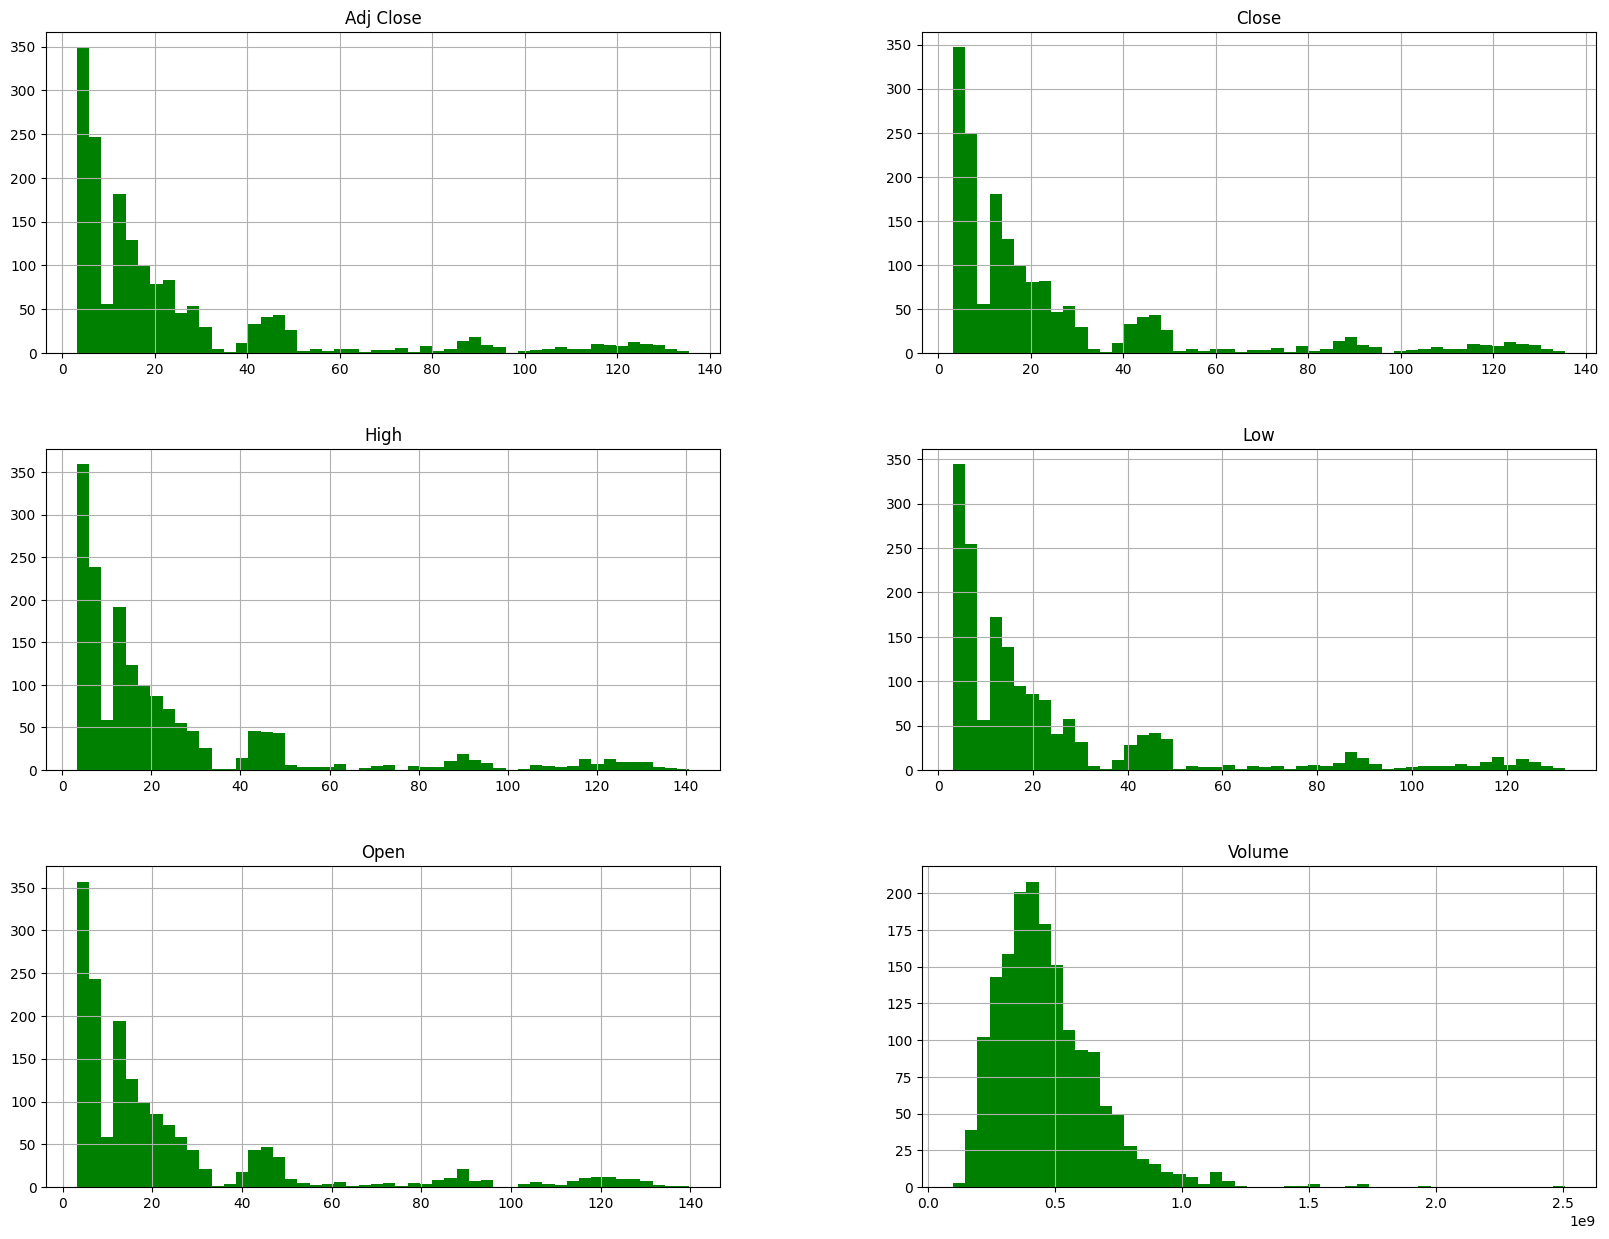

In [134]:
#histogram
df_nvidia.hist(bins=50, color="green", figsize=(20,15))
plt.show()

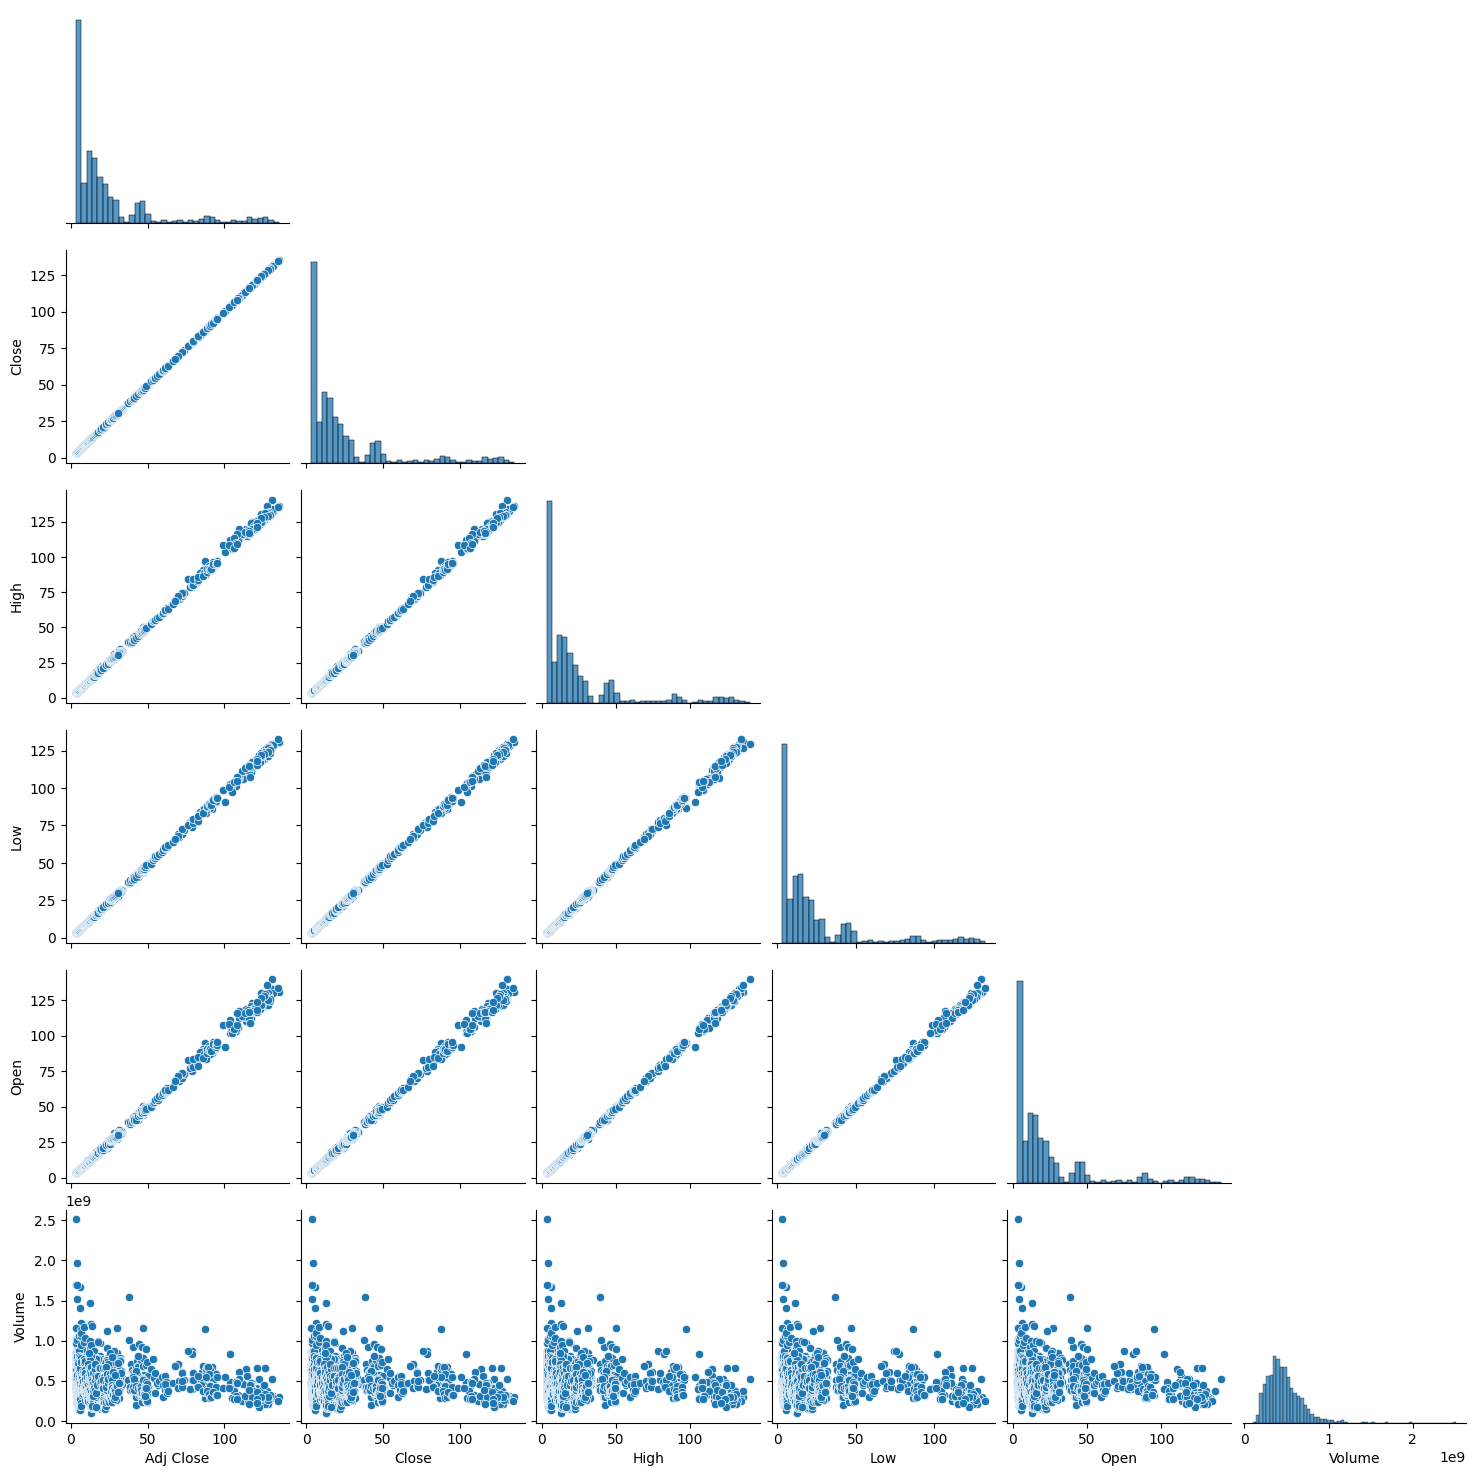

In [135]:
# Looking at some real data, where we don't know the number of clusters already
for col in df_nvidia.columns:
    df_nvidia[col] = pd.to_numeric(df_nvidia[col])

sns.pairplot(df_nvidia, corner=True)
plt.show()

In [136]:
# Feature Engineering (Moving Averages and Volatility)

# Calculate the 50-day Simple Moving Average (SMA), which smooths the closing price
# by averaging it over the last 50 days to identify short-term trends.
df_nvidia['SMA_50'] = df_nvidia['Close'].rolling(window=50).mean()

# Calculate the 200-day Simple Moving Average (SMA), which smooths the closing price
# over the last 200 days to identify long-term trends.
df_nvidia['SMA_200'] = df_nvidia['Close'].rolling(window=200).mean()

# Calculate the 50-day rolling standard deviation (Volatility), which measures the
# dispersion of closing prices over the last 50 days, indicating market volatility.
df_nvidia['Volatility'] = df_nvidia['Close'].rolling(window=50).std()

df_nvidia.dropna(inplace=True)

In [137]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1498 entries, 2018-10-16 to 2024-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   1498 non-null   float64
 1   Close       1498 non-null   float64
 2   High        1498 non-null   float64
 3   Low         1498 non-null   float64
 4   Open        1498 non-null   float64
 5   Volume      1498 non-null   float64
 6   SMA_50      1498 non-null   float64
 7   SMA_200     1498 non-null   float64
 8   Volatility  1498 non-null   float64
dtypes: float64(9)
memory usage: 117.0 KB


In [138]:
# Define features and target
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'SMA_200', 'Volatility']
target = 'Close'

X = df_nvidia[features]
y = df_nvidia[target]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [139]:
# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [140]:
# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [141]:
# Model 3: LSTM (Deep Learning)
X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)
y_pred_lstm = lstm_model.predict(X_test_lstm)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1549.1721
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1254.6459
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1181.6199
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1109.9081
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 859.9109
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1049.2412
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 844.2145
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 959.3778
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 951.0658
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 726.5955
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [142]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of {model_name}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R^2 Score: {r2}")
    print("-" * 50)

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test_lstm, y_pred_lstm.flatten(), "LSTM")

Performance of Linear Regression:
MAE: 3.7442641579824946e-14
RMSE: 4.533246760646722e-14
R^2 Score: 1.0
--------------------------------------------------
Performance of Random Forest:
MAE: 0.10554045543670651
RMSE: 0.293079513660993
R^2 Score: 0.9999135899219934
--------------------------------------------------
Performance of LSTM:
MAE: 12.567535699208577
RMSE: 29.15462109237544
R^2 Score: 0.1449169930618608
--------------------------------------------------


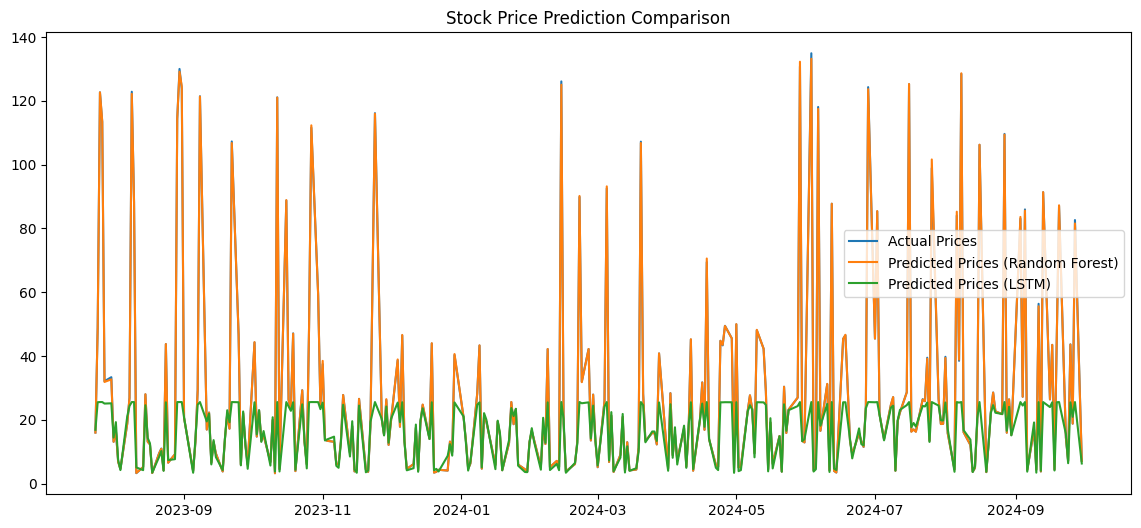

In [143]:
# Time Horizon Impact
plt.figure(figsize=(14, 6))
plt.plot(df_nvidia.index[-len(y_test):], y_test.values, label='Actual Prices')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_rf, label='Predicted Prices (Random Forest)')
plt.plot(df_nvidia.index[-len(y_test):], y_pred_lstm.flatten(), label='Predicted Prices (LSTM)')
plt.legend()
plt.title("Stock Price Prediction Comparison")
plt.show()